In [18]:
# Import libraries for data handling, visualization, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import joblib

In [19]:
# Load the preprocessed dataset created earlier
full_df = pd.read_csv(r"C:\Users\nimak\Documents\Projects\bank-marketing-classification\data\bank_marketing_processed.csv")
X = full_df.drop('y', axis=1)
y = full_df['y']

In [20]:
# Load the trained Gradient Boosting model and get feature importances
model = joblib.load('best_model_gradient_boosting.pkl')
importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select features with importance greater than a threshold
selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()
X_selected = X[selected_features]

In [21]:
# Split data using only the selected important features
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
# Tune hyperparameters of Gradient Boosting to improve performance
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [23]:
# Evaluate the best model selected from grid search
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report (Tuned Gradient Boosting):")
print(classification_report(y_test, y_pred))


Classification Report (Tuned Gradient Boosting):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7310
           1       0.69      0.56      0.62       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.79      8238
weighted avg       0.92      0.92      0.92      8238



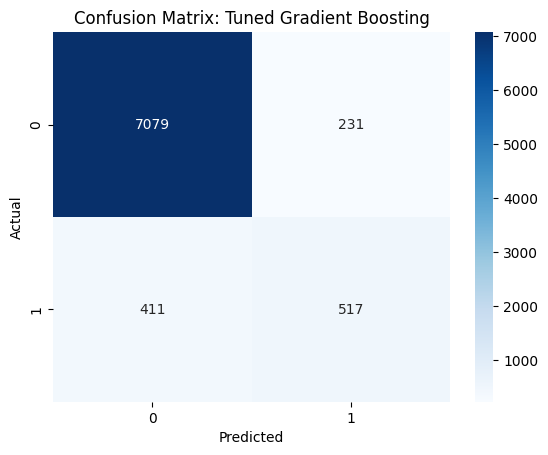

In [24]:
# Show confusion matrix for visual analysis of classification
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Tuned Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# Save the tuned Gradient Boosting model to disk
joblib.dump(best_model, 'best_model_gb_tuned.pkl')

['best_model_gb_tuned.pkl']

In [26]:
#  Optional: Use stacking classifier to ensemble Gradient Boosting with other models
base_learners = [
    ('gb', GradientBoostingClassifier(**grid.best_params_)),
    ('dt', DecisionTreeClassifier(max_depth=5)),
    ('svc', SVC(probability=True))
]

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train, y_train)
y_stack_pred = stack_model.predict(X_test)

print("\nClassification Report (Stacking Classifier):")
print(classification_report(y_test, y_stack_pred))


Classification Report (Stacking Classifier):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.70      0.55      0.62       928

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.79      8238
weighted avg       0.92      0.92      0.92      8238



In [27]:
# Adjust classification threshold to maximize F1-score
y_probs = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold: {best_threshold:.2f}")

y_pred_opt = (y_probs >= best_threshold).astype(int)
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))

Optimal threshold: 0.38

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7310
           1       0.63      0.73      0.67       928

    accuracy                           0.92      8238
   macro avg       0.80      0.84      0.82      8238
weighted avg       0.93      0.92      0.92      8238



In [28]:
# Multiply pairs of numeric features to discover synergistic interactions
numeric_feats = importance_df[importance_df['Importance'] > 0.01]['Feature'].tolist()
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_feats]), columns=numeric_feats)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_feats]), columns=numeric_feats)

fused_scores = {}
for f1, f2 in combinations(numeric_feats, 2):
    X_fused_train = X_train_scaled.copy()
    X_fused_test = X_test_scaled.copy()

    fused_col = f"{f1}_{f2}_fused"
    X_fused_train[fused_col] = X_train_scaled[f1] * X_train_scaled[f2]
    X_fused_test[fused_col] = X_test_scaled[f1] * X_test_scaled[f2]

    model_temp = GradientBoostingClassifier(**grid.best_params_)
    model_temp.fit(X_fused_train, y_train)
    y_pred_fused = model_temp.predict(X_fused_test)
    fused_scores[fused_col] = f1_score(y_test, y_pred_fused)

# Print top 10 fused features by F1 score
top_fused = sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n🔍 Top 10 fused feature pairs by F1-score:")
for name, score in top_fused:
    print(f"{name} → F1-score: {score:.4f}")



🔍 Top 10 fused feature pairs by F1-score:
duration_poutcome_success_fused → F1-score: 0.6267
euribor3m_pdays_fused → F1-score: 0.6262
duration_euribor3m_fused → F1-score: 0.6237
nr.employed_poutcome_success_fused → F1-score: 0.6233
euribor3m_month_oct_fused → F1-score: 0.6226
pdays_month_oct_fused → F1-score: 0.6219
euribor3m_cons.price.idx_fused → F1-score: 0.6212
poutcome_success_month_oct_fused → F1-score: 0.6202
nr.employed_cons.price.idx_fused → F1-score: 0.6193
poutcome_success_cons.price.idx_fused → F1-score: 0.6191


In [29]:
# Save the model and optimal threshold together for future use
optimized_model_package = {
    'model': best_model,
    'threshold': best_threshold,
    'features': X_selected.columns.tolist()  # Save which features were used
}

joblib.dump(optimized_model_package, 'optimized_threshold_model.pkl')
print("✅ Optimized threshold model saved as 'optimized_threshold_model.pkl'")

✅ Optimized threshold model saved as 'optimized_threshold_model.pkl'
